In [62]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import re
import pickle
import os
from collections import defaultdict
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import gensim

from google.colab import drive
drive.mount('/content/drive/')

import sys
path_folder = "/content/drive/MyDrive/dsprojects/dsproject_grev/" # parent of current src folder
sys.path.insert(0, path_folder+"/src/features/")
import util

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [63]:
# [name, ingredients], or [ingredients]
# subsequent filenames
vocab_column_names = ["ingredients"]+["name"]
use_old_recipe = 0
valid_vocab_column_names = ["tags","ingredients","name","steps","description"]
assert all((arg in valid_vocab_column_names) for arg in vocab_column_names)


# taco, mojito are not in word2vec(ingredients), so ignore this option
#

In [64]:
#file_name_tfidf = "recipe_tfidf.pkl"
#file_name_word2vec = "recipe_word2vec.pkl"
#file_name_tfidf = "ingredients_tfidf.pkl"
#file_name_word2vec = "ingredients_word2vec.pkl"
file_name_tfidf = "tfidf_"+("_".join(vocab_column_names))+".pkl"
file_name_word2vec = "word2vec_"+("_".join(vocab_column_names))+".pkl"

path_folder_data = os.path.join(path_folder,"data")
path_data_raw_recipes =  os.path.join(path_folder_data,"raw","RAW_recipes.csv")
raw_recipes_df = pd.read_csv(path_data_raw_recipes)
path_output_tfidf = os.path.join(path_folder_data, "temp", file_name_tfidf)
path_output_word2vec = os.path.join(path_folder_data, "temp", file_name_word2vec)

In [65]:
# vectorizer method, stopwords, max_df
# liststr_columns
class Temp_Recipe_Vectorizer_Builder:
    def __init__(self, vectorizer, food_vocab_column):
        self.vectorizer = (vectorizer)
        food_vocab_vectorizer = vectorizer.fit(food_vocab_column)

        self.fitted_vectorizer = food_vocab_vectorizer

        food_vocab_vectorized = vectorizer.transform(food_vocab_column)

        self.vectorized_matrix = food_vocab_vectorized.tocsc()
        if type(vectorizer) == Pipeline:
            self.vocab2idx = self.fitted_vectorizer.named_steps["count"].vocabulary_
        else:
            self.vocab2idx = self.fitted_vectorizer.vocabulary_
        self.idx2vocab = dict((v, k) for k, v in self.vocab2idx.items())
    def get_top_n_features_by_colwise_aggfunc(self, func, n=1000, as_words=True):
        result = np.array(func(self.vectorized_matrix, axis=0))[0].argsort()[-n:]
        if as_words:
            result = [self.idx2vocab[i] for i in result]
        return result

In [66]:
def get_liststr_columns(raw_recipes_df, column_names=["ingredients","name"]):
    liststr_columns_list = []
    if "tags" in column_names:
        cleaned_tag_column = util.dataclean_strliststr_to_liststr(raw_recipes_df["tags"])
        liststr_columns_list.append(cleaned_tag_column)
    if "ingredients" in column_names:
        cleaned_ingredients_column = util.dataclean_strliststr_to_liststr(raw_recipes_df["ingredients"])
        liststr_columns_list.append(cleaned_ingredients_column)
    if "name" in column_names:
        cleaned_name_column = util.dataclean_everygram_str_to_liststr(raw_recipes_df["name"],2)
        liststr_columns_list.append(cleaned_name_column)
    if "steps" in column_names:
        cleaned_steps_column = util.dataclean_strliststr_to_liststr(raw_recipes_df["name"])
        liststr_columns_list.append(cleaned_steps_column)
    if "description" in column_names:
        cleaned_description_column = util.dataclean_everygram_str_to_liststr(raw_recipes_df["name"],2)
        liststr_columns_list.append(cleaned_description_column)
    liststr_columns = util.dataclean_join_liststr_columns(liststr_columns_list)
    return liststr_columns
def build_food_vocab_vectorizer(raw_recipes_df, vocab_column_names):
    liststr_columns = get_liststr_columns(raw_recipes_df, vocab_column_names)
    stop_words = stopwords.words("english")
    food_vocab_column = (liststr_columns).apply(lambda x: " ".join(x))
    vectorizer = Pipeline(steps=[('count', CountVectorizer(stop_words=stop_words)), ('tfidf', TfidfTransformer())])
    recipe_vectorizer_builder = Temp_Recipe_Vectorizer_Builder(vectorizer, food_vocab_column)
    return recipe_vectorizer_builder

In [67]:
food_vocab_vectorizer = build_food_vocab_vectorizer(raw_recipes_df, vocab_column_names)

In [70]:
for word in ["mojito","egg", "taco"]:
    print(word in food_vocab_vectorizer.vocab2idx)
    print(word+"s" in food_vocab_vectorizer.vocab2idx)

True
False
True
True
True
False


In [71]:
liststr_columns = get_liststr_columns(raw_recipes_df, vocab_column_names)
word2vec_model = util.dataclean_word2vec(liststr_columns)

In [72]:
for word in ["mojito","egg", "taco"]:
    print(word in word2vec_model.wv)
    print(word+"s" in word2vec_model.wv)

False
False
True
True
False
False


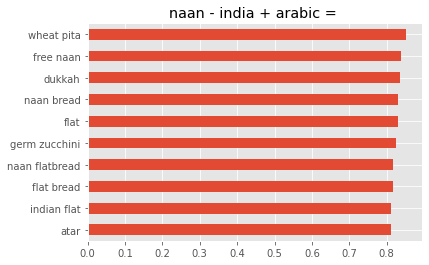

In [57]:
(util.word2vec_arithmetic(word2vec_model, "india","naan","arabic" ))

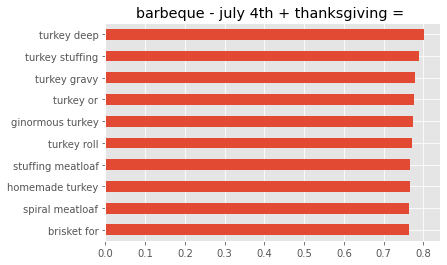

In [58]:
util.word2vec_arithmetic(word2vec_model, "july 4th", "barbeque", "thanksgiving" )

In [59]:
first_time = True

In [61]:
if first_time:
    print("write")
    with open(path_output_tfidf, "wb") as f:
        pickle.dump(food_vocab_vectorizer, f)
        f.close()
else:
    print("read")
    with open(path_output_tfidf, "rb") as f:
        food_vocab_vectorizer = pickle.load(f)
        f.close()
if first_time:
    print("write")
    #liststr_columns = get_liststr_columns(raw_recipes_df, vocab_column_names)
    #word2vec_model = util.dataclean_word2vec(liststr_columns)
    with open(path_output_word2vec, "wb") as f:
        pickle.dump(word2vec_model, f)
        f.close()
else:
    print("read")
    with open(path_output_word2vec, "rb") as f:
        word2vec_model = pickle.load(f)
        f.close()
if use_old_recipe:
    with open(os.path.join(path_folder_data, "temp", "recipe_word2vec"), "rb") as f:
        word2vec_model = pickle.load(f)
        f.close()

write
write
